In [1]:
#generate heatmap for given image.
#If you want to generate heatmap for other image, change IMAGE_PATH
from IPython.display import clear_output


import torch
import torchvision.transforms as transforms
import numpy as np
import PIL
import matplotlib.pyplot as plt
from Datasets.ILSVRC_classes import classes
import torch.utils.model_zoo as model_zoo
import torch.optim as optim
from torch.autograd import Variable
from einops.layers.torch import Reduce, Rearrange


#models
import Methods.AGCAM.ViT_for_AGCAM as ViT_Ours
import timm
from Methods.LRP.ViT_LRP import vit_base_patch16_224 as LRP_vit_base_patch16_224

#methods
from Methods.AGCAM.AGCAM import AGCAM, OptiAGCAM
from Methods.AGCAM.Better_AGCAM import Better_AGCAM
from Methods.LRP.ViT_explanation_generator import LRP
from Methods.AttentionRollout.AttentionRollout import VITAttentionRollout

MODEL = 'vit_base_patch16_224'
IMG_SIZE=224
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device: ", device)

#Select Image which you want to generate a heatmap for.
# IMAGE_PATH = "C:/Users/ngcao/Documents/dev/uni/Thesis/TFE_XAI_ViT/AGC/ILSVRC/Data/CLS-LOC/val/n01498041/ILSVRC2012_val_00001935.JPEG"
# IMAGE_PATH = "samples/catdog.png"
# IMAGE_PATH = "samples/ILSVRC2012_val_00000125.jpeg"
# IMAGE_PATH = "samples/ILSVRC2012_val_00001372.jpeg"
IMAGE_PATH = "samples/ILSVRC2012_val_00001854.jpeg"

# Load the model parameter provided by the Timm library
state_dict = model_zoo.load_url('https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth', progress=False, map_location='cpu')

# Image transformation for ImageNet ILSVRC 2012.
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

# For convert the input image into original distribution to display
unnormalize = transforms.Compose([
    transforms.Normalize([0., 0., 0.], [1/0.5, 1/0.5, 1/0.5]),
    transforms.Normalize([-0.5, -0.5, -0.5], [1., 1., 1.,])
])

c:\Users\ngcao\Documents\dev\uni\Thesis\TFE_XAI_ViT\AGC\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device:  cuda


In [2]:
def optimize(model, image, transformed_img):
    
    rollout_model = timm.create_model(MODEL, pretrained=True, num_classes=1000).to(device)
    rollout_model.load_state_dict(state_dict, strict=True)
    rollout_model.eval()
    
    BetterCAM_Method = OptiAGCAM(model)
    
    prediction, heatmap, output_truth = BetterCAM_Method.generate(image)
    print("[DEBUG]: headtmap.shape: " + str(heatmap.shape))
    
    width = 14
    lr = 0.01
    prev = 1e10
    max_iter = 100
    agc_score = torch.full((heatmap.shape[0],), 0.5, dtype=torch.float, requires_grad=True)
    optimizer = optim.Adam([agc_score], lr=lr)
    
    for i in range(max_iter):  
        # print("[DEBUG]: === Step " + str(i))
        # print("[DEBUG]: agc_score requires_grad: ", agc_score.requires_grad)
        
        alpha = torch.nn.functional.softmax(agc_score, dim = 0).to(device)
        alpha = alpha.unsqueeze(1).unsqueeze(2).repeat(1, 1, heatmap.shape[2])
        new_heatmap = torch.sum((alpha * heatmap), axis = 0)
        
        new_image = new_heatmap.reshape(1, width, width)
        
        new_image = transforms.Resize((224, 224))(new_image) * transformed_img
        
       
        output_mask = rollout_model(new_image.unsqueeze(0)).to(device)
        
        L2 = torch.nn.MSELoss()
        # loss = L2(output_truth[0, prediction.item()], output_mask[0, prediction.item()]) 
        loss = output_truth[0, prediction.item()] - output_mask[0, prediction.item()]
        # loss =  output_mask[0, prediction.item()] - output_truth[0, prediction.item()] #SAI
        # loss = torch.abs(output_truth[0, prediction.item()] - output_mask[0, prediction.item()])
        
        # print("[DEBUG]: loss value at step {}: {}".format(i, loss.item()))
        # print("[DEBUG]: loss.grad_fn: ", loss.grad_fn)  
        
        # print("Loss: ", output_mask[0, prediction.item()] - output_truth[0, prediction.item()])
        # print("[DEBUG]: agc_score.grad before backward: ", agc_score.grad)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        # print("[DEBUG]: agc_score.grad after backward: ", agc_score.grad)
        optimizer.step()
        
        if i % (max_iter//10) == 0:
            if loss > prev:
                print('Optimization stopped due to convergence...')
                # my_cam = agc_score * better_agc_heatmap
                print(agc_score.is_cuda)
                print(heatmap.is_cuda)
                # my_cam = (agc_score.to(device) * heat_map).sum(axis=(0, 1)).reshape(1, width, width)

                return new_heatmap.reshape(1, width, width)
            prev = loss
        print('Learning Progress: %2.2f %%   ' %((i+1)/max_iter *100))

    alpha = torch.nn.functional.softmax(agc_score, dim = 0).to(device)
    alpha = alpha.unsqueeze(1).unsqueeze(2).repeat(1, 1, heatmap.shape[2])
    new_heatmap = torch.sum((alpha * heatmap), axis = 0)
    my_cam = new_heatmap.reshape(1, width, width)

    return my_cam
    
            
    

[DEBUG]: headtmap.shape: torch.Size([144, 1, 196])
Learning Progress: 1.00 %   
Learning Progress: 2.00 %   
Learning Progress: 3.00 %   
Learning Progress: 4.00 %   
Learning Progress: 5.00 %   
Learning Progress: 6.00 %   
Learning Progress: 7.00 %   
Learning Progress: 8.00 %   
Learning Progress: 9.00 %   
Learning Progress: 10.00 %   
Learning Progress: 11.00 %   
Learning Progress: 12.00 %   
Learning Progress: 13.00 %   
Learning Progress: 14.00 %   
Learning Progress: 15.00 %   
Learning Progress: 16.00 %   
Learning Progress: 17.00 %   
Learning Progress: 18.00 %   
Learning Progress: 19.00 %   
Learning Progress: 20.00 %   
Learning Progress: 21.00 %   
Learning Progress: 22.00 %   
Learning Progress: 23.00 %   
Learning Progress: 24.00 %   
Learning Progress: 25.00 %   
Learning Progress: 26.00 %   
Learning Progress: 27.00 %   
Learning Progress: 28.00 %   
Learning Progress: 29.00 %   
Learning Progress: 30.00 %   
Learning Progress: 31.00 %   
Learning Progress: 32.00 %  

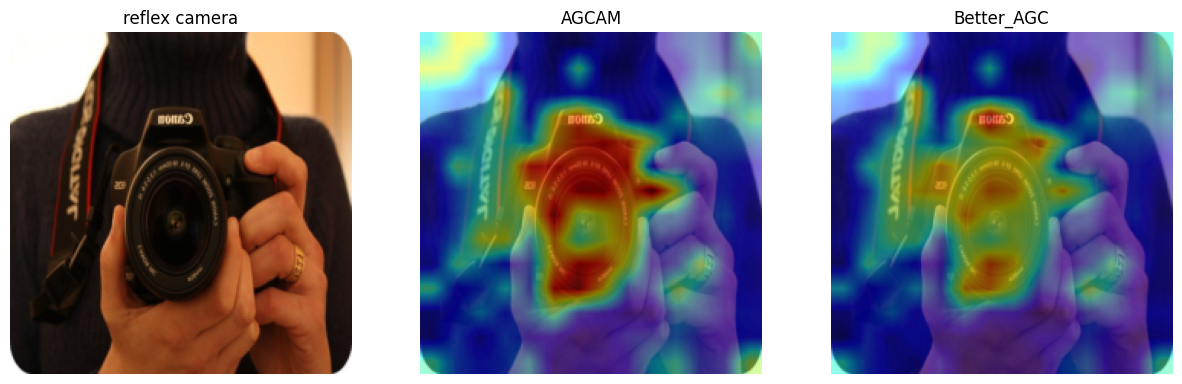

In [3]:
# Open the input image and transform
image = PIL.Image.open(IMAGE_PATH)
image = transform(image)
transformed_img = image.to(device)
image = image.unsqueeze(0).to(device)

class_num=1000

# Models and Methods
model = ViT_Ours.create_model(MODEL, pretrained=True, num_classes=class_num).to(device)
model.load_state_dict(state_dict, strict=True)
model.eval()

AGCCAM_Method = AGCAM(model)
# BetterCAM_Method = Better_AGCAM(model)
with torch.enable_grad():
    prediction, agc_heatmap = AGCCAM_Method.generate(image)
    
    agc_heatmap = transforms.Resize((224, 224))(agc_heatmap[0])
    agc_heatmap = (agc_heatmap - agc_heatmap.min())/(agc_heatmap.max()-agc_heatmap.min())
    agc_heatmap = agc_heatmap.detach().cpu().numpy()
    agc_heatmap = np.transpose(agc_heatmap, (1, 2, 0))


    my_cam = optimize(model, image, transformed_img)
    print("[DEBUG]: my_cam.shape: ", my_cam.shape)
    my_cam = transforms.Resize((224, 224))(my_cam)
    my_cam = (my_cam - my_cam.min())/(my_cam.max()-my_cam.min())
    my_cam = my_cam.detach().cpu().numpy()
    my_cam = np.transpose(my_cam , (1, 2, 0))
    
    # Display the results
    image = unnormalize(image)
    image = image.detach().cpu().numpy()[0]
    image = np.transpose(image, (1, 2, 0))
    fig, axs = plt.subplots(1,3, figsize=(15, 70))
    axs[0].set_title(classes[prediction.item()])
    axs[0].imshow(image)
    axs[0].axis('off')
    
    axs[1].set_title('AGCAM')
    axs[1].imshow(image)
    axs[1].imshow(agc_heatmap, cmap='jet', alpha=0.5)
    axs[1].axis('off')
  
    axs[2].set_title('Better_AGC')
    axs[2].imshow(image)
    axs[2].imshow(my_cam, cmap='jet', alpha=0.5)
    axs[2].axis('off')
    